In [1]:
NAME = 'conv-rusentiment'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append("drive/MyDrive/Colab Notebooks")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

import datetime

import mydata as md

data = md.Data('drive/MyDrive/cache')


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [5]:
raw_train_ds, raw_valid_ds, raw_test_ds = data.load('ru-sentiment')

In [6]:
max_features = 20000
sequence_length = 1000

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [7]:
vectorize_layer.adapt(raw_train_ds.map(lambda x,y: x))

In [8]:
train_ds = data.vectorize(raw_train_ds, vectorize_layer)
valid_ds = data.vectorize(raw_valid_ds, vectorize_layer)
test_ds = data.vectorize(raw_test_ds, vectorize_layer)


In [9]:
train_ds_filtered = train_ds.filter(lambda x,y: tf.equal(len(x),1000))
valid_ds_filtered = valid_ds.filter(lambda x,y: tf.equal(len(x),1000))
test_ds_filtered = test_ds.filter(lambda x,y: tf.equal(len(x),1000))

In [10]:
#train_ds_batch=train_ds.shuffle(len(train_ds), reshuffle_each_iteration=False).batch(64)
train_ds_batch=train_ds_filtered.batch(256)

valid_ds_batch=valid_ds_filtered.batch(256)
test_ds_batch=test_ds_filtered.batch(256)

In [12]:
embedding_dim=64

embedding_layer = tf.keras.layers.Embedding(
    input_dim=(max_features),
    output_dim=embedding_dim,
    mask_zero=False
)

model = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    tf.keras.layers.Conv1D(128, 5, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=None, kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, kernel_regularizer=None, kernel_initializer='he_normal')
])
model.summary()

model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         41088     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

In [13]:
checkpoint_filepath = f"models/checkpoint_{NAME}.weights.h5"

log_dir = f"logs/fit-{NAME}/{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}"

epochs = 10
history = model.fit(
    train_ds_batch,
    validation_data=valid_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
)

Epoch 1/10
742/742 [==============================] - 138s 180ms/step - loss: 0.7239 - accuracy: 0.6587 - f1_score: 0.6343 - val_loss: 0.5694 - val_accuracy: 0.7451 - val_f1_score: 0.7327
Epoch 2/10
742/742 [==============================] - 51s 69ms/step - loss: 0.5474 - accuracy: 0.7562 - f1_score: 0.7450 - val_loss: 0.5425 - val_accuracy: 0.7549 - val_f1_score: 0.7443
Epoch 3/10
742/742 [==============================] - 52s 70ms/step - loss: 0.4875 - accuracy: 0.7869 - f1_score: 0.7770 - val_loss: 0.5446 - val_accuracy: 0.7586 - val_f1_score: 0.7475
Epoch 4/10
742/742 [==============================] - 51s 69ms/step - loss: 0.4412 - accuracy: 0.8097 - f1_score: 0.8007 - val_loss: 0.5599 - val_accuracy: 0.7564 - val_f1_score: 0.7469
Epoch 5/10
742/742 [==============================] - 56s 75ms/step - loss: 0.4058 - accuracy: 0.8263 - f1_score: 0.8184 - val_loss: 0.5868 - val_accuracy: 0.7569 - val_f1_score: 0.7458
Epoch 6/10
742/742 [==============================] - 52s 70ms/step 

In [14]:
raw_tab_train_ds, raw_tab_valid_ds, raw_tab_test_ds = data.load('tabiturient')

In [15]:
train_tab_ds = data.vectorize(raw_tab_train_ds, vectorize_layer)
valid_tab_ds = data.vectorize(raw_tab_valid_ds, vectorize_layer)
test_tab_ds = data.vectorize(raw_tab_test_ds, vectorize_layer)


In [16]:
model.evaluate(test_ds.batch(256))

42/42 [==============================] - 4s 57ms/step - loss: 0.6729 - accuracy: 0.7602 - f1_score: 0.7499


[0.6728779673576355, 0.7601668238639832, 0.7499367594718933]

In [17]:
model.evaluate(test_tab_ds.batch(256))

2/2 [==============================] - 2s 212ms/step - loss: 2.1733 - accuracy: 0.3528 - f1_score: 0.3621


[2.173318862915039, 0.35277777910232544, 0.36208558082580566]

In [18]:
model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

In [19]:
history = model.fit(
    train_tab_ds.batch(16),
    validation_data=valid_tab_ds.batch(16),
    epochs=10
)

Epoch 1/10
180/180 [==============================] - 37s 189ms/step - loss: 2.1526 - accuracy: 0.4096 - f1_score: 0.4130 - val_loss: 1.6542 - val_accuracy: 0.4568 - val_f1_score: 0.4653
Epoch 2/10
180/180 [==============================] - 2s 9ms/step - loss: 1.8536 - accuracy: 0.4426 - f1_score: 0.4450 - val_loss: 1.4204 - val_accuracy: 0.4819 - val_f1_score: 0.4867
Epoch 3/10
180/180 [==============================] - 2s 12ms/step - loss: 1.6314 - accuracy: 0.4812 - f1_score: 0.4798 - val_loss: 1.2701 - val_accuracy: 0.5097 - val_f1_score: 0.5069
Epoch 4/10
180/180 [==============================] - 2s 9ms/step - loss: 1.4757 - accuracy: 0.4868 - f1_score: 0.4802 - val_loss: 1.1770 - val_accuracy: 0.5320 - val_f1_score: 0.5236
Epoch 5/10
180/180 [==============================] - 3s 16ms/step - loss: 1.3831 - accuracy: 0.5174 - f1_score: 0.5055 - val_loss: 1.1150 - val_accuracy: 0.5348 - val_f1_score: 0.5236
Epoch 6/10
180/180 [==============================] - 3s 19ms/step - loss: 

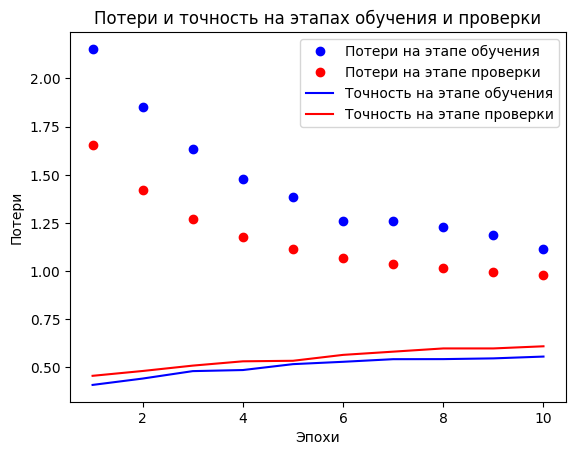

In [20]:
data.plot(history)

In [21]:
model.evaluate(test_tab_ds.batch(256))

2/2 [==============================] - 0s 35ms/step - loss: 1.0206 - accuracy: 0.5361 - f1_score: 0.5173


[1.0205516815185547, 0.5361111164093018, 0.5173494815826416]

In [22]:
model.save(f"drive/MyDrive/models/model-{NAME}.keras")